# 2) Simplified Replication

This script reconstructs Figure 9 from the Sikora 2005 paper.
Uses Ca only at one debth!

In [1]:
# File: scripts/ganglion_cell.py
# Requires: nrnivmodl-compiled MODs: cas.mod, cad.mod, tsbp.mod, spike.mod, ribbon_tiger.mod

from neuron import h
import os
import numpy as np
import matplotlib.pyplot as plt

--No graphics will be displayed.


## -----------------------------------------------------------
## PART 1 — Loading mechanisms and initializing model
## -----------------------------------------------------------

In [2]:
# Load compiled channel mechanisms and standard run system
h.nrn_load_dll("/Users/lillikiessling/Documents/Stanford/Code/BC_model/Ion_channels/arm64/libnrnmech.dylib")
h.load_file('stdrun.hoc') 
h.load_file("nrn/cells/gc.nrn")            # defines soma, dend1[], dend2[], dend3[], dend4[], dend5[], dend6[]

1.0

In [3]:
# Global synaptic parameters 

NumSites = 10      # number of release sites per ribbon (from mod file)
GMAX  = 0.00256    # AMPA/NMDA maximal conductance (default in model)
GMAXN = 0.00011    # secondary NMDA-related conductance
ABSR  = 0.0        # Absolute refractory period (turned off)

## -----------------------------------------------------------
## PART 2 — Construct additional RGC compartments (axon)
## -----------------------------------------------------------

In [4]:
# Create sections representing the axon initial segment and axon
initseg = h.Section(name='initseg')
narrowr = h.Section(name='narrowr')
axon    = h.Section(name='axon')
preSyn  = h.Section(name='preSyn')


In [5]:
# Geometry of axonal components 
initseg.nseg = int(45/15)  # 45 µm long, segment length ~15 µm
initseg.L    = 45
initseg.diam = 1

narrowr.nseg = int(90/15)  # 90 µm region
narrowr.L    = 90
narrowr.diam = 0.4

axon.nseg = int(1000/15)   # 1 mm axon (67 segments)
axon.L    = 1000
axon.diam = 1

In [6]:
# Connect axonal components to soma

# Connect initseg(0) to soma(1)
initseg.connect(h.soma(1), 0)

# Connect narrow region after the initial segment
narrowr.connect(initseg(1), 0)

# Connect long axon after narrow region
axon.connect(narrowr(1), 0)

axon

In [7]:
# Insert global Ca2+ mechanism into RGC 'cas' into every RGC compartment

for sec in h.allsec():
    sec.insert('cas')
    # cas exposes taur_cas in many but not all sections
    try:
        sec.taur_cas = 1.5   # identical to Sikora's HOC code
    except:
        pass

# TODO: Check what happens if I use my own Calcium mechanisms

## -----------------------------------------------------------
## PART 3 — Construct Bipolar Cell Terminal
## -----------------------------------------------------------

In [8]:
# Configure presynaptic bipolar cell terminal (1 compartment)

preSyn.insert('tsbp')   # L-type Ca channel controlling release
preSyn.insert('cad')    # Calcium diffusion shells

# Ensure presynaptic terminal does NOT use 'cas' (RGC calcium mechanism)
try:
    preSyn.uninsert('cas')
except:
    pass

# Geometry (identical to HOC)
preSyn.L    = 10
preSyn.diam = 10
preSyn.depth_cad = 0.025  # 25 nm shell depth
preSyn.taur_cad  = 0.1    # fast calcium removal
preSyn.gcabar_tsbp = 0.0012  # L-type Ca channel density

NEURON: cai is being written at the same location by cad and cas
 near line 0
 ^


In [9]:
# Voltage clamp on presynaptic terminal (BC)
bpclamp = h.VClamp(preSyn(0.5))
# Total duration (stable for 5500 ms)
bpclamp.dur[0] = 5500

In [ ]:
# Load the bipolar command waveform

vec = h.Vector()
f = h.File()

# If file cannot be opened, simulation still runs but clamp amplitude = 0
if not f.ropen("bp_Sikora.dat"):
    h('printf("WARNING: cannot open bp_Sikora.dat; clamp waveform = 0.\\n")')
    vec = h.Vector(0)
else:
    # Read up to 192000 floating-point values (exactly like HOC scanf)
    vec.scanf(f, 192000, 1, 1)
    f.close()

# Duplicate for for future use (if needed)
vec2 = vec.c()

# Play into bpclamp._ref_amp[0] with dt = 0.025 ms (Sikora's original timeres)
vec.play(bpclamp._ref_amp[0], 0.025)

Vector[0]

# -----------------------------------------------------------
# Part 4 - Spike Mechanisms
# -----------------------------------------------------------


In [11]:
# Insert default spike mechanism into every section

for sec in h.allsec():
    sec.insert('spike')
    # These default values correspond to dendritic channel densities
    # from the original HOC model.
    try:
        sec.gcabar_spike = 0.002      # Ca channel density
        sec.gkbar_spike  = 0.012      # K channel density
        sec.gabar_spike  = 0.036      # generic A-type / leak channel
        sec.gkcbar_spike = 0.000001   # Ca-dependent K
        sec.gnabar_spike = 0.025      # Very low dendritic Na density
    except:
        pass

# TODO: find other way to produce spike

In [12]:
# SPECIALIZED CHANNEL DENSITIES FOR SOMA, AIS, NARROW REGION, AXON

# Override channel densities for soma
h.soma.insert('spike')
h.soma.gcabar_spike = 0.0015
h.soma.gkbar_spike  = 0.018
h.soma.gabar_spike  = 0.054
h.soma.gkcbar_spike = 0.000065
h.soma.gnabar_spike = 0.10


# Initial segment (AIS) — highest Na density for spike initiation
initseg.insert('spike')
initseg.gcabar_spike = 0.0015
initseg.gkbar_spike  = 0.018
initseg.gabar_spike  = 0.054
initseg.gkcbar_spike = 0.000065
initseg.gnabar_spike = 0.125

# Narrow region — strong K, lower Na
narrowr.insert('spike')
narrowr.gcabar_spike = 0.0
narrowr.gkbar_spike  = 0.018
narrowr.gabar_spike  = 0.054
narrowr.gkcbar_spike = 0.000065
narrowr.gnabar_spike = 0.1

# Axon — mostly Na and K, no Ca
axon.insert('spike')
axon.gcabar_spike = 0.0
axon.gkbar_spike  = 0.018
axon.gabar_spike  = 0.0
axon.gkcbar_spike = 0.000065
axon.gnabar_spike = 0.07


## -----------------------------------------------------------
## Part 5 - Reversal Potentials + Passive Conductance + RA
## -----------------------------------------------------------

In [ ]:
# Set reversal potentials, passive membrane properties, and Ra
for sec in h.allsec():

    # "spike.mod" exposes mod_modulator_spike, which defaults to 0
    for seg in sec:
        try:
            seg.mod_modulator_spike = 0
        except AttributeError:
            pass

    # Ionic reversal potentials
    sec.ena = 35       # Na reversal
    sec.ek  = -75      # K reversal

    # Calcium concentrations (externally 1.8 mM)
    sec.cao = 1.8
    sec.cai = 0.0001   # basal internal Ca (100 nM)

    # Insert passive leak channel
    sec.insert('pas')
    sec.g_pas = 1/70000.0   # ~1.43e-5 S/cm² leak
    sec.e_pas = -65         # leak reversal = resting potential

    # Axial resistance
    sec.Ra = 110             # identical to Sikora

In [14]:
# REMOVE SPIKE CHANNELS FROM PRESYNAPTIC BC TERMINAL
# This is CRUCIAL because otherwise the BC terminal would spike.
# Sikora’s release model assumes:
# BC terminal is voltage-clamped, not active
# no Na/K channels in the BC terminal
try:
    preSyn.uninsert('spike')
except Exception:
    pass

## -----------------------------------------------------------
## PART 6 — Ribbon Synapses
## -----------------------------------------------------------


In [15]:
# Helper: create a ribbon synapse at midpoint of a section
def make_syn_at(sec, idx):
    """Create a ribbon_tiger at sec(0.5) with Ca pointers hooked up."""
    syn = h.ribbon_tiger_simple(sec(0.5))
    # WHY: setpointer requires Python _ref to map POINTER variables.
    h.setpointer(preSyn(0.5).ca_ion._ref_cai,  'preCA', syn)
    syn.gmax  = 0.00128
    syn.gmaxN = 0.0001
    syn.mg    = 0.5
    return syn


In [16]:
# Allocate synapse arrays (23 synapses × 3 parallel ribbons)
synapse  = [None]*23
synapse2 = [None]*23
synapse3 = [None]*23

# PLACE SYNAPSES ON dend1[0..11]
for i in range(12):
    sec = h.dend1[i]
    synapse[i]  = make_syn_at(sec, i)
    synapse2[i] = make_syn_at(sec, i)
    synapse3[i] = make_syn_at(sec, i)

# so far: 12 synaptic locations × 3 ribbons = 36 synapses created

# Remaining 11 synapse placements (identical to Sikora's HOC)
placements = [
    (synapse, 12, h.dend1[19]),
    (synapse, 13, h.dend2[0]),
    (synapse, 14, h.dend2[1]),
    (synapse, 15, h.dend2[10]),
    (synapse, 16, h.dend3[0]),
    (synapse, 17, h.dend1[22]),
    (synapse, 18, h.dend4[0]),
    (synapse, 19, h.dend5[0]),
    (synapse, 20, h.dend6[0]),
    (synapse, 21, h.dend6[1]),
    (synapse, 22, h.dend6[2]),

    (synapse2, 12, h.dend1[19]),
    (synapse2, 13, h.dend2[0]),
    (synapse2, 14, h.dend2[1]),
    (synapse2, 15, h.dend2[10]),
    (synapse2, 16, h.dend3[0]),
    (synapse2, 17, h.dend1[22]),
    (synapse2, 18, h.dend4[0]),
    (synapse2, 19, h.dend5[0]),
    (synapse2, 20, h.dend6[0]),
    (synapse2, 21, h.dend6[1]),
    (synapse2, 22, h.dend6[2]),

    (synapse3, 12, h.dend1[19]),
    (synapse3, 13, h.dend2[0]),
    (synapse3, 14, h.dend2[1]),
    (synapse3, 15, h.dend2[10]),
    (synapse3, 16, h.dend3[0]),
    (synapse3, 17, h.dend1[22]),
    (synapse3, 18, h.dend4[0]),
    (synapse3, 19, h.dend5[0]),
    (synapse3, 20, h.dend6[0]),
    (synapse3, 21, h.dend6[1]),
    (synapse3, 22, h.dend6[2]),
]

# Create synapses according to placement table
for arr, idx, sec in placements:
    arr[idx] = make_syn_at(sec, idx)

# after this: 23 synaptic locations × 3 synapse arrays = 69 ribbon synapses

In [17]:
# Apply global synaptic parameters to every synapse
def set_stim():
    """
    Ensure that all 69 ribbon synapses share the same
    global parameters (GMAX, GMAXN, ABSR, mg).

    This mirrors Sikora's procedure of adjusting parameters
    before each simulation.
    """
    for arr in (synapse, synapse2, synapse3):
        for s in arr:
            if s is None:
                continue
            s.gmax       = GMAX
            s.gmaxN      = GMAXN
            s.AbsRefract = ABSR
            s.mg         = 0.5

set_stim()

## ---------------------------------------------------
## Part 7 - Recording Vectors + Simulation Execution
## ---------------------------------------------------

In [18]:
# Recording vectors 
# Simulation time (ms)
t_vec = h.Vector().record(h._ref_t)

# Panel A: bipolar command voltage waveform
v_bipolar_cmd = h.Vector().record(bpclamp._ref_amp[0])

# Panel B: presynaptic Ca2+ at depth = 25 nm 
ca1_vec = h.Vector().record(preSyn(0.5)._ref_cai)

# Panel C: Release Rate (Orate) from all ribbon synapses
Orate_vecs = []
for arr in (synapse, synapse2, synapse3):
    for s in arr:
        v = h.Vector().record(s._ref_Orate)
        Orate_vecs.append(v)

# Panel D: Release Events (release_start[i])
# Each synapse has release_start[NumSites] -> 69 synapses × 10 sites = 690 NEURON vectors
release_event_flags = []
for arr in (synapse, synapse2, synapse3):
    for s in arr:
        for i in range(NumSites):
            v = h.Vector().record(s._ref_release_start[i])
            release_event_flags.append(v)


# Panel E: Synaptic Current (EPSC) from all ribbon synapses (sum of AMPA + NMDA from all ribbon synapses)
I_syn_vecs = []

for arr in (synapse, synapse2, synapse3):
    for s in arr:
        if s is None: 
            continue
        v = h.Vector().record(s._ref_i)
        I_syn_vecs.append(v)

# Panel F: RGC soma membrane voltage
v_soma = h.Vector().record(h.soma(0.5)._ref_v)

In [19]:
# DEBUG VECTORS
debug_t = h.Vector()
debug_t.record(h._ref_t)

debug_v_pre = h.Vector()
debug_v_pre.record(preSyn(0.5)._ref_v)

debug_cai_pre = h.Vector()
debug_cai_pre.record(preSyn(0.5)._ref_cai)

debug_ica_pre = h.Vector()
debug_ica_pre.record(preSyn(0.5)._ref_ica)  # L-type Ca current

debug_Orate = h.Vector()
debug_Orate.record(synapse[0]._ref_Orate)

debug_release = h.Vector()
debug_release.record(synapse[0]._ref_release_start[0])

debug_preCAnow = h.Vector().record(synapse[0]._ref_preCAnow)
debug_rate_const = h.Vector().record(synapse[0]._ref_rate_constant)


print("===ORIGINAL PYTHON DEBUG ===")
print("Initial preSyn cai: ", preSyn(0.5).cai)
print("Pointer test (synapse 0): preCA = ", synapse[0].preCA)


===ORIGINAL PYTHON DEBUG ===
Initial preSyn cai:  0.0001
Pointer test (synapse 0): preCA =  0.0001


In [20]:
# Run simulation
h.dt = 0.025 # ms
h.tstop = 5500
h.CVode().active(0)
h.finitialize(-65)
h.run()

0.0

In [21]:
# Convert
t_d = np.array(debug_t)
v_pre = np.array(debug_v_pre)
cai_pre = np.array(debug_cai_pre)
ica_pre = np.array(debug_ica_pre)

# After your existing debug output, add:
print("\n=== CALCIUM CURRENT ===")
print(f"ica at t=0.475ms: {ica_pre[19]:.6e} mA/cm2")
print(f"Expected approximately: -1.632e-03 mA/cm2 (from original)")
print(f"Ratio: {ica_pre[19]/(-1.632e-03):.3f}")

# Print first few values
print("=== PRESYNAPTIC CALCIUM DEBUG ===")
for i in range(20):
    print(f"t={t_d[i]:.3f} ms  v={v_pre[i]:.2f} mV  cai={cai_pre[i]:.6f} mM  ica={ica_pre[i]:.6e} mA/cm2")

Or = np.array(debug_Orate)

print("=== RELEASE RATE DEBUG ===")
for i in range(20):
    print(f"t={t_d[i]:.3f}, Orate={Or[i]:.6f} (/s), cai={cai_pre[i]:.6f} mM")

rel = np.array(debug_release)
print("=== RELEASE START DEBUG ===")
print(rel[:50])

pc = np.array(debug_preCAnow)
rc = np.array(debug_rate_const)

print("=== HILL INPUT DEBUG ===")
for i in range(20):
    print(f"t={t_d[i]:.3f}, preCAnow={pc[i]:.6f}, rate_const={rc[i]:.6f}")


=== CALCIUM CURRENT ===
ica at t=0.475ms: -1.632181e-03 mA/cm2
Expected approximately: -1.632e-03 mA/cm2 (from original)
Ratio: 1.000
=== PRESYNAPTIC CALCIUM DEBUG ===
t=0.000 ms  v=-65.00 mV  cai=0.000100 mM  ica=-1.213178e-08 mA/cm2
t=0.025 ms  v=-48.13 mV  cai=0.000100 mM  ica=-1.213178e-08 mA/cm2
t=0.050 ms  v=-47.49 mV  cai=0.000115 mM  ica=-3.508534e-04 mA/cm2
t=0.075 ms  v=-47.46 mV  cai=0.000154 mM  ica=-1.022045e-03 mA/cm2
t=0.100 ms  v=-47.46 mV  cai=0.000202 mM  ica=-1.421091e-03 mA/cm2
t=0.125 ms  v=-47.46 mV  cai=0.000248 mM  ica=-1.588115e-03 mA/cm2
t=0.150 ms  v=-47.46 mV  cai=0.000286 mM  ica=-1.646580e-03 mA/cm2
t=0.175 ms  v=-47.46 mV  cai=0.000318 mM  ica=-1.662092e-03 mA/cm2
t=0.200 ms  v=-47.46 mV  cai=0.000343 mM  ica=-1.662266e-03 mA/cm2
t=0.225 ms  v=-47.46 mV  cai=0.000363 mM  ica=-1.657799e-03 mA/cm2
t=0.250 ms  v=-47.46 mV  cai=0.000379 mM  ica=-1.652579e-03 mA/cm2
t=0.275 ms  v=-47.46 mV  cai=0.000392 mM  ica=-1.647869e-03 mA/cm2
t=0.300 ms  v=-47.46 mV  ca

In [22]:
# Postprocessing
# Convert to numpy
t    = t_vec.as_numpy()
v_cmd = v_bipolar_cmd.as_numpy()
ca1  = ca1_vec.as_numpy()
v_s  = v_soma.as_numpy()


# Compute averaged release rate (Panel C)
Orate_np = np.array([v.as_numpy() for v in Orate_vecs])
avg_rate = Orate_np.mean(axis=0) / NumSites


# Extract release event times: detect changes in release_start arrays
event_trains = []
for v in release_event_flags:
    arr = np.array(v)
    changes = np.where(np.diff(arr) != 0)[0]
    times = arr[changes + 1]
    event_trains.append(times)


# Compute EPSC (sum of synaptic currents)
I_syn_np = np.array([v.as_numpy() for v in I_syn_vecs])
EPSC = I_syn_np.sum(axis=0)      # nA
EPSC_pA = EPSC * 1000            # convert to pA

## ------------------------------------------
## Part 8 - Plotting
## ------------------------------------------

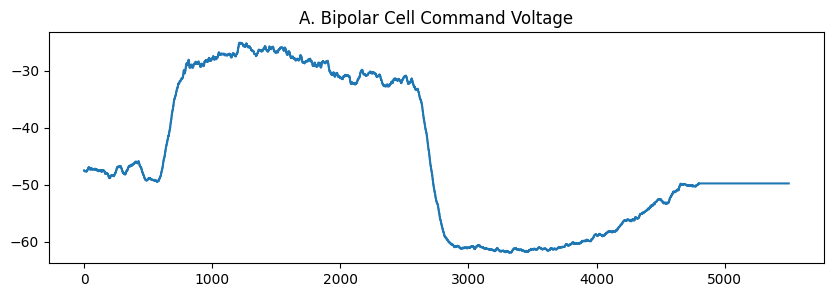

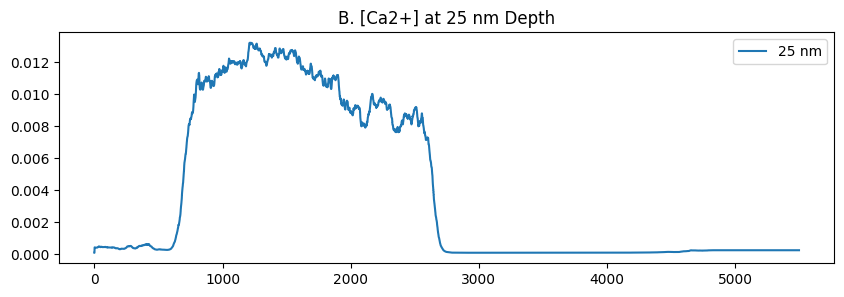

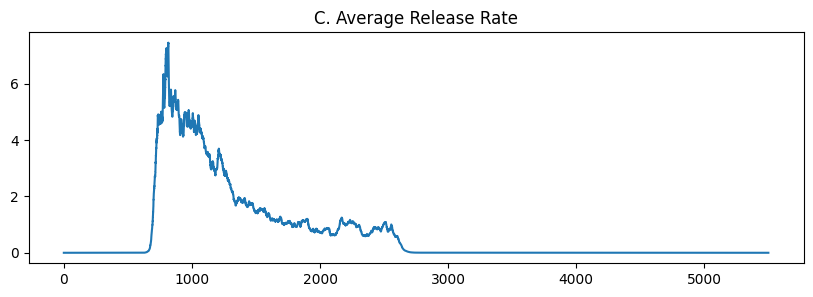

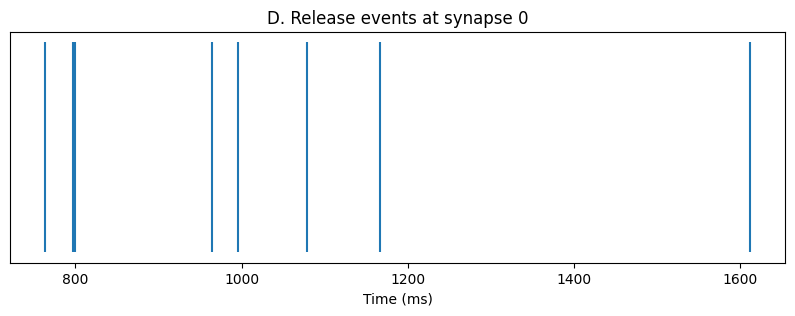

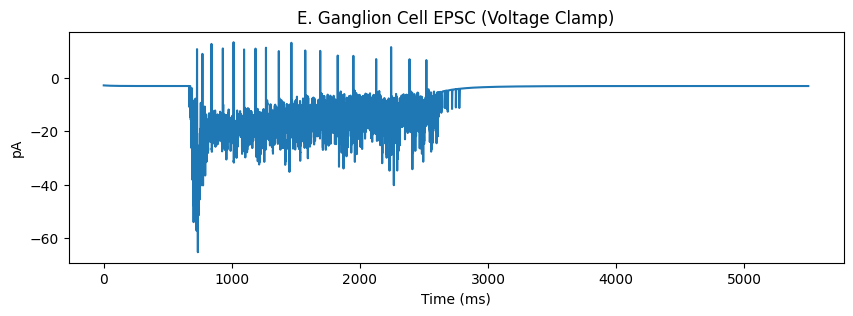

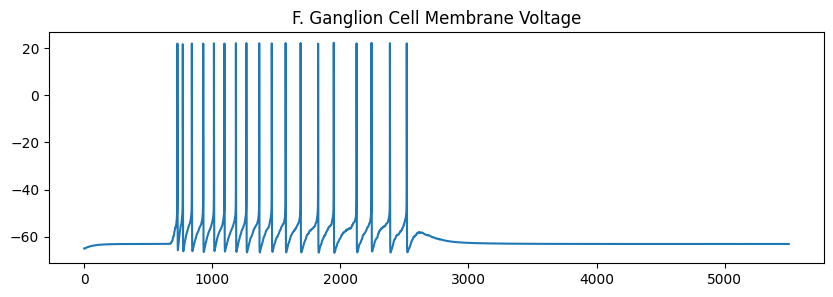

In [23]:
# A — Bipolar Cell Command Voltage
plt.figure(figsize=(10, 3))
plt.plot(t, v_cmd)
plt.title("A. Bipolar Cell Command Voltage")
plt.show()

# B — Presynaptic Ca2+ at 25 nm depth (sharp increases during depolarization)
plt.figure(figsize=(10, 3))
plt.plot(t, ca1, label="25 nm")
plt.legend()
plt.title("B. [Ca2+] at 25 nm Depth")
plt.show()


# C — Average Release Rate (Orate across 69 ribbon synapses -> smooth rate)
plt.figure(figsize=(10, 3))
plt.plot(t, avg_rate)
plt.title("C. Average Release Rate")
plt.show()

#D — Release Events (shows all vesicle release events -> raster of vertical tick marks)
k = 0
plt.figure(figsize=(10, 3))
plt.vlines(event_trains[k], 0, 1)
plt.yticks([])
plt.title(f"D. Release events at synapse {k}")
plt.xlabel("Time (ms)")
plt.show()

# E —  Ganglion Cell EPSC (Voltage Clamp) (Sum of all AMPA+NMDA synaptic currents from all 69 synapses -> inward current during release bursts)
plt.figure(figsize=(10, 3))
plt.plot(t, EPSC_pA)
plt.title("E. Ganglion Cell EPSC (Voltage Clamp)")
plt.ylabel("pA")
plt.xlabel("Time (ms)")
plt.show()

# F — Ganglion Cell Membrane Voltage (shows natural RGC spiking, NOT voltage clamp -> action potentials during strong synaptic activation)
plt.figure(figsize=(10, 3))
plt.plot(t, v_s)
plt.title("F. Ganglion Cell Membrane Voltage")
plt.show()